## Info
Setting up the model to receate the hydrosynamics of the Solitary Wave model from BarSed.

Author: WaveHello

Date: 07/15/2024

### Notes
ADV data and pressure data for the solitary wave cases aren't in the folders I downloaded. I'm not sure where that data is or if it was recorded.

In [34]:
# import default modules
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import scipy
import pandas as pd
from scipy import special

# Set global constants
PI = np.pi
G = 9.81

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(r"C:\ERDC\xbeach-toolbox")

In [35]:
# Import the classes that represent the runs
# Add the library to the path
sys.path.append(r"C:\ERDC\BarSed")

# Import the library modules

from lib.data_classes.Run import Run

In [36]:
from xbTools.grid.creation import xgrid
from xbTools.xbeachtools import XBeachModelSetup
from xbTools.xbeachpost import XBeachModelAnalysis
from xbTools.general.executing_runs import generate_batch_script, run_batch_script


In [37]:
# Fuctions
def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path

def create_directory_if_not_exists(directory_path):
    """
    Creates a directory if it does not already exist.
    
    Parameters:
    directory_path (str): The path of the directory to create.
    """
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
    else:
        print(f"Directory '{directory_path}' already exists.")

def moving_average_filter(data, window_size):
    """
    Applies a moving average filter to the input data.

    Parameters:
    - data: The input array of data points (list or numpy array).
    - window_size: The size of the moving window.

    Returns:
    - filtered_data: The filtered data as a numpy array.
    """
    # Convert data to a numpy array if it is not already
    data = np.array(data)
    
    # Ensure the window size is an integer
    window_size = int(window_size)
    
    # Check if window size is greater than 0 and less than or equal to the length of data
    if window_size <= 0 or window_size > len(data):
        raise ValueError("Window size must be greater than 0 and less than or equal to the length of the data.")
    
    # Compute the moving average using np.convolve with 'valid' mode to avoid padding effects
    filtered_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    
    return filtered_data

### Set the information for the selected Run

In [38]:
# Import the raw bathymetry
# Set the important paths
barsed_data_path = r"D:\ERDC\BarSed"

# Set the information needed for specifying the run
# Run number
run_number = "001"

# Run id
run_id = f"RUN{run_number}"

# Mat file for the first run
run_name = r"{}.mat".format(run_id)


### Set data that isn't directly available in the inputs

### Get the bathymetry for the model

In [39]:
# Name of the bathy data binary
bathy_file_name = r"bathy.mat"

# Path to where I'm storing the bathymetry data
bathy_file_path = os.path.join(barsed_data_path, bathy_file_name)

print(f"Bathy file path: {bathy_file_path}")

Bathy file path: D:\ERDC\BarSed\bathy.mat


### Get the path to the wave gauge data

In [40]:

# Name of the folder containing the wave data
WG_data_folder_name = r"WG" 

# Path to where I'm storing the bathymetry data
WG_data_path = os.path.join(barsed_data_path, WG_data_folder_name)

# Path to the selected wave gauge data
wave_data_path = os.path.join(WG_data_path, run_name)

print(f"Run{run_number} wave mat file path: {wave_data_path}")

Run001 wave mat file path: D:\ERDC\BarSed\WG\RUN001.mat


### Get the path to the adv data
The period of the wave maker is stored in this data. Not using it for anything else at the momement.

In [41]:
# Name of the folder containing the adv data
ADV_data_folder_name = r"ADV"

# Path to where the velocity data is being stored
ADV_data_path = os.path.join(barsed_data_path, ADV_data_folder_name)

# Path to the adv data for the selected run
ADV_file_path = os.path.join(ADV_data_path, run_name)

print(f"{ADV_data_folder_name} file path: {ADV_data_path}")
print("{} Data for mat file path: {}".format(ADV_data_folder_name, ADV_file_path))

ADV file path: D:\ERDC\BarSed\ADV
ADV Data for mat file path: D:\ERDC\BarSed\ADV\RUN001.mat


### Collect the bathymetry data

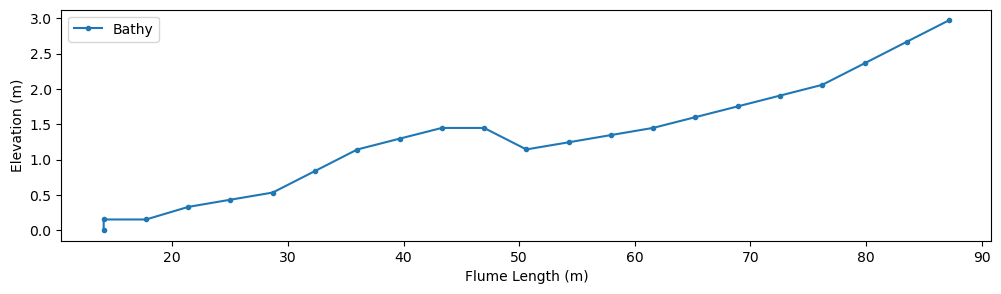

In [42]:
# Make a plot of the bathymetry to make sure the data is right
# Load the .mat file
bathy_dict = scipy.io.loadmat(bathy_file_path)

# Get the bathymetry data
bathy_df = pd.DataFrame(bathy_dict["bathy"], columns = ["x_loc", "z_loc"])

bathy_df.plot("x_loc", "z_loc", marker = ".", 
              figsize = (12, 3), label = "Bathy", 
              ylabel= "Elevation (m)", xlabel = "Flume Length (m)"
)

plt.legend()
plt.show()

### Construct the Run object
This object will help organize the data and help store the data

In [43]:
Run_data = Run(id = run_id, wave_file_path=wave_data_path,
              ADV_file_path = ADV_file_path)

print(Run_data)


id: RUN001
Start Date: None
Wave Data File path: D:\ERDC\BarSed\WG\RUN001.mat
Num pressure gagues: None
Num advs: None


### Collect the wave gauge data

New Number of 17 wave gauges
Wave Maker information:
Number of times: 20863


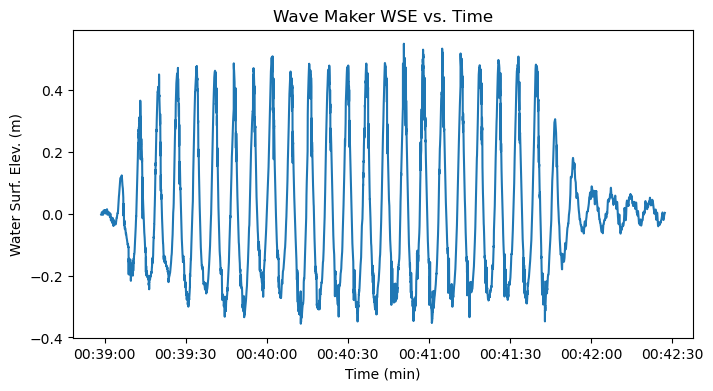

In [44]:
Run_data.load_wave_data()

print(Run_data.wave_maker)

Run_data.wave_maker.quick_wse_plot()

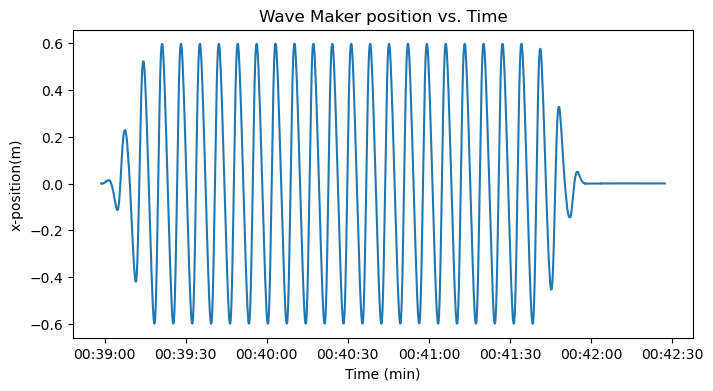

In [45]:
Run_data.wave_maker.quick_position_plot()

## Smoothing the surface data

In [46]:
# Convert the wave maker date_time to time in seconds
first_time = Run_data.wave_maker.date_time[0]

seconds_from_first = np.array([(dt - first_time).total_seconds() for dt in Run_data.wave_maker.date_time])


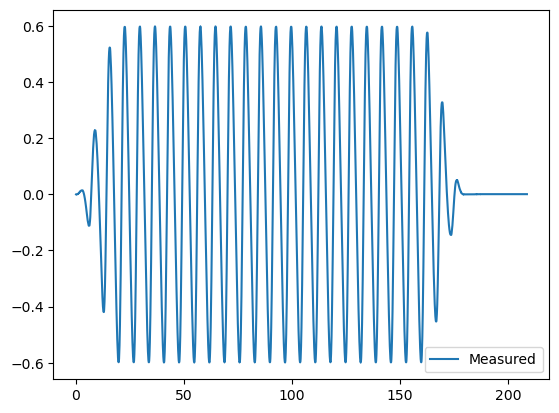

In [47]:
# Plot the theoretical and the measured wave maker displacement

fig, axs = plt.subplots(nrows = 1, ncols = 1)

axs = np.atleast_1d(axs)

shift = 10
wave_maker_loc = Run_data.wave_maker.position
axs[0].plot(seconds_from_first, wave_maker_loc, label = "Measured")

plt.legend()
plt.show()

## Generating the xBeach inputs

### Generating the Bathymetry

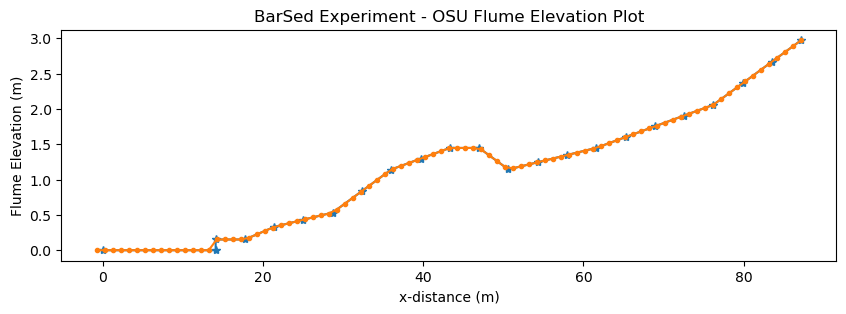

In [48]:
# Reinterpolate the raw bathymetry for the xBeach model

x = np.array(bathy_df["x_loc"])
z = np.array(bathy_df["z_loc"])

# Add the zero to the arrays
x = np.concatenate(([0.0], x))
z = np.concatenate(([0.0], z))

# x_zero = np.array(0, )
xgr, zgr = xgrid(x, z, dxmax = 0.1, dxmin = 1)


fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 3))

# Convert axs to an array so I can iterate over it if needed
axs = np.atleast_1d(axs)

axs[0].plot(x, z    , marker = "*", label = "Bathy")
axs[0].plot(xgr, zgr, marker = ".", label = "xgr")
# axs[0].axhline(y = 3.0)
axs[0].set_xlabel("x-distance (m)")
axs[0].set_ylabel("Flume Elevation (m)")

plt.title("BarSed Experiment - OSU Flume Elevation Plot")
plt.show()
#TODO: Need to look into what the proper procedure for 


### Generating the wave data

In [49]:
print(Run_data)

id: RUN001
Start Date: 2015-01-22
Wave Data File path: D:\ERDC\BarSed\WG\RUN001.mat
Num pressure gagues: None
Num advs: None


In [50]:
print(Run_data.wave_gauges[0])

Wave Gauge Type: self_calibrating
Gauge Id: 1
Location: (17.728, -1.269)


Water surface elevation: 2.971 [m]


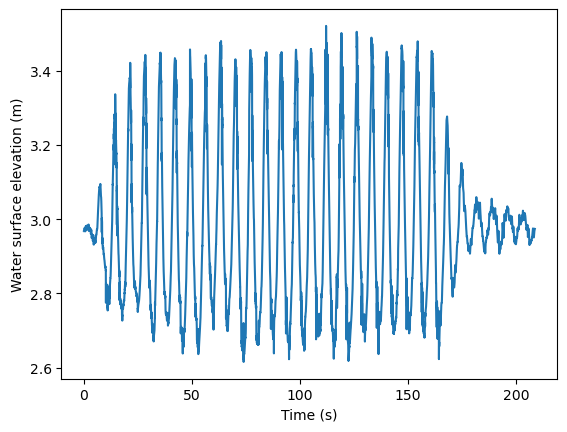

In [51]:
# Set information
zs0 = zgr.max()

# Offset the water suface elevation from the bottom
eta = zs0 + Run_data.wave_maker.eta_wm
# Generate the wave boundary condition

# Calc the velocity of the

print(f"Water surface elevation: {zs0} [m]")
plt.plot(seconds_from_first, eta)
plt.xlabel("Time (s)")
plt.ylabel("Water surface elevation (m)")
plt.show()

### Generating the computational params for the model

In [52]:
xb_setup = XBeachModelSetup('Rand_vel_v1_1')

xb_setup.set_grid(xgr, None, zgr, posdwn=-1, alfa=0)
xb_setup.set_nebed(np.ones_like(zgr))
xb_setup.set_friction(np.ones_like(zgr))

In [53]:
seconds_from_first

array([0.00000000e+00, 9.99800000e-03, 1.99960000e-02, ...,
       2.08599995e+02, 2.08610003e+02, 2.08620001e+02])

In [54]:
x0 = Run_data.wave_maker.position
displacement = Run_data.wave_maker.position

In [55]:
u = displacement[:-1]/(seconds_from_first[1:] - seconds_from_first[:-1])

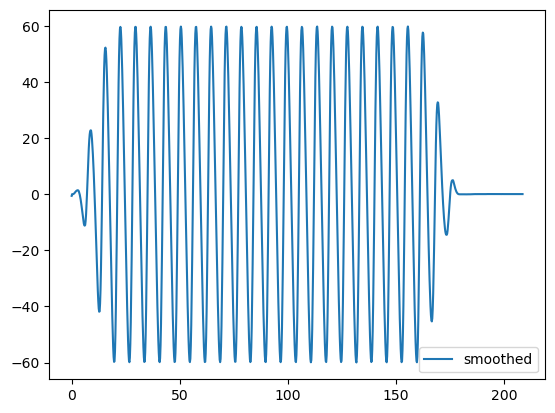

In [56]:
from scipy.interpolate import UnivariateSpline

num_vals = 1000

spline = UnivariateSpline(seconds_from_first[1:], u, s= 0.001)
disp_time = np.linspace(seconds_from_first.min(), seconds_from_first.max(), num_vals)
smooth_disp = spline(disp_time)

# plt.plot(seconds_from_first[1:], displacement, label = "original")
plt.plot(disp_time, smooth_disp, label = "smoothed")
plt.legend()

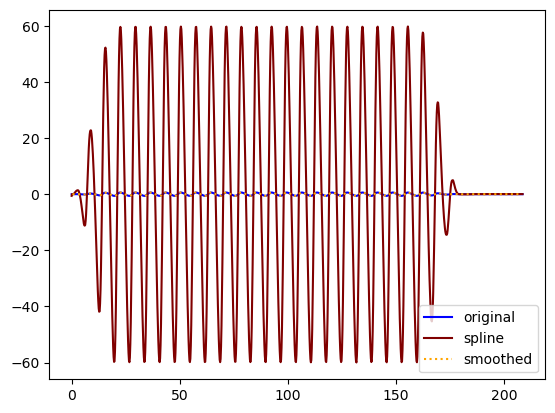

In [57]:
window_size = 75

window_time = moving_average_filter(seconds_from_first[1:], window_size)
window_disp = moving_average_filter(displacement, window_size)

plt.plot(seconds_from_first, displacement, color = "blue"  , label = "original")
plt.plot(disp_time, smooth_disp              , color = "maroon", label = "spline")
plt.plot(window_time, window_disp[1:]            , color = "orange", label = "smoothed", linestyle = "dotted")
plt.legend()

In [58]:
eta_window = moving_average_filter(eta, window_size)

In [59]:
window_disp

array([0.00012416, 0.00012983, 0.00013266, ..., 0.00045298, 0.00045393,
       0.00045204])

C:\Users\johnm\AppData\Local\Temp\ipykernel_13588\2725248353.py:1: RuntimeWarning: divide by zero encountered in divide
  u_spline = smooth_disp/disp_time


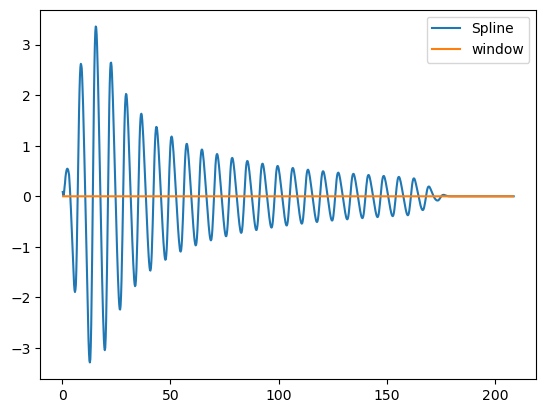

In [60]:
u_spline = smooth_disp/disp_time 
u_window = (window_disp[:-1] - window_disp[1:])/window_time
plt.plot(disp_time, u_spline, label = "Spline")
plt.plot(window_time, u_window, label = "window")
plt.legend()

In [61]:
# Addding a zero at the start of the array so that 
u_window    = np.insert(u_window        , 0, 0)
eta_window  = np.insert(eta_window[:-1] , 0, zs0)
window_time = np.insert(window_time[:-1], 0, 0)

In [62]:

# Generate a random u velocity for the time being
u_avg = Run_data.wave_maker.position

zs_scaling = 1.0
u_scale = 1.0

# u_window = np.ones(len(u_window))

boun_U_dict = {"make_file": True,
               "file_name": "boun_U.bcf",
               "dimension": "scalar",
               "variable_dict": {
                   "t" : window_time,
                   "zs": zs_scaling * (eta_window[:-1] - zs0), # Pertubation from the intial water surface
                   "U" : u_scale * u_window, 
               }         
}

xb_setup.set_waves('ts_nonh', input_struct=boun_U_dict)

print(f"WARNING: USING a zs scaling of {zs_scaling}. This doesn't make physical sense")


In [63]:
xb_setup.set_params({ "wbctype"     : "ts_nonh",
                    #  "taper"        : 0.0,
                     "wavemodel"    : "nonh",
                     "nonh"         : 1,
                     "CFL"          : 0.5,
                     "lateralwave"  : "neumann",
                     "zs0"          : zs0,
                     'bedfriccoef'  : 0.0,
                    #  "order"        : 2,
                    #  "ARC"          : 1,
                     "front"        : "nonh_1d", "back" : "abs_1d",
                     "left"         : "wall", "right": "wall",
                     "tstop"        : boun_U_dict["variable_dict"]["t"].max(),
                     "outputformat" : "netcdf",
                     "tintm"        : 0.1,
                     "tintp"        : 0.1,
                     "tintg"        : 0.1,
                     'nglobalvar'   : ['zs', 'zb', 'H', "u", "v"],
})

The following params were not found in the JSON: 
{'nonh': 1}


In [64]:
xb_setup.input_par

{'par': {'nonh': 1},
 'Wave boundary condition parameters': {'wbctype': 'ts_nonh',
  'lateralwave': 'neumann'},
 'Physical processes': {'wavemodel': 'nonh'},
 'Model time': {'CFL': 0.5, 'tstop': 208.2400001466667},
 'Tide boundary conditions': {'zs0': 2.971},
 'Flow parameters': {'bedfriccoef': 0.0},
 'Flow boundary condition parameters': {'front': 'nonh_1d',
  'back': 'abs_1d',
  'left': 'wall',
  'right': 'wall'},
 'Output': {'outputformat': 'netcdf',
  'tintm': 0.1,
  'tintp': 0.1,
  'tintg': 0.1},
 '_Output': {'nglobalvar': ['zs', 'zb', 'H', 'u', 'v']}}

### Generating the model files

In [65]:
# Get the folder of the current script
script_dir = get_script_directory()

# Generate the model directory
model_dir = os.path.join(script_dir, f"")

create_directory_if_not_exists(model_dir)

exe_path = r"C:\ERDC\tutorial_models\XBeach_1.24.6057_Halloween_win64_netcdf\xbeach.exe"

# Make the batch file in the model dir
generate_batch_script(model_dir, exe_path, batch_file_name = "run_model.bat", 
                      include_cd = False, batch_file_folder = None)


batch_file_path = os.path.join(model_dir, "run_model.bat")


Directory 'c:\ERDC\BarSed_xBeach_models\Solitary_Wave_Models\Run_001\' already exists.


In [66]:
xb_setup.write_model(model_dir, num_dec_dig=10)

C:\ERDC\xbeach-toolbox\xbTools\xbeachtools.py:960: SyntaxWarning: invalid escape sequence '\T'
  ax.text(-thetamin_uv[0], -thetamin_uv[1], '$\Theta_{min}$ = '+f'{self.thetamin:.2f}', ha = 'left', va = 'center')
C:\ERDC\xbeach-toolbox\xbTools\xbeachtools.py:961: SyntaxWarning: invalid escape sequence '\T'
  ax.text(-thetamax_uv[0], -thetamax_uv[1], '$\Theta_{max}$ = '+f'{self.thetamax:.2f}', ha = 'left', va = 'center')


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 20788 and the array at index 2 has size 20789

In [ ]:
# Write the wave maker data to a txt file

# Time, location, wse
data = {"time"     : seconds_from_first,     
        "location" : Run_data.wave_maker.position,
        "wse"      : Run_data.wave_maker.eta_wm + zs0
        }
df = pd.DataFrame(data)
display(df)
df.to_csv("wave_maker.csv", index = False)

,time,location,wse
0,0.000000,-0.000015,2.968093
1,0.009998,0.000198,2.968093
2,0.019996,0.000056,2.968028
3,0.030004,0.000127,2.968157
4,0.040002,0.000056,2.968350
...,...,...,...
20858,208.579999,0.000340,2.973698
20859,208.590007,0.000410,2.973698
20860,208.599995,0.000340,2.973762
20861,208.610003,0.000410,2.973827
